In [50]:
import pandas as pd
import numpy as np

In [51]:
df = pd.read_csv("../data/classification/count_dataset_for_multilabel_v2.csv")
df.head()

,project_name,package#kotlin#B,package#kotlin#C,package#kotlin#Class,package#kotlin#Host,package#kotlin#LibPackCase1,package#kotlin#LibPackCase2,package#kotlin#Libraries,package#kotlin#Library,package#kotlin#My,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
0,01joy#news-search-engine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,05bit#peewee-async,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0k#shyaml,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0xAX#linux-insides,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

def get_xgboost_clf(X_train, y_train, X_test, y_test):
    clf = XGBClassifier(learning_rate=0.05,
                        n_estimators=100,
                        max_depth=5,
                        min_child_weight=5.0,
                        gamma=1,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        objective="binary:logistic",
                        random_state=42)
    
    clf.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])

    return clf

def save_xgboost_clf(clf, name):
    clf.save_model(f"./models_v2/{name}.json")
    
def load_xgboost_clf(clf, name):
    clf = XGBClassifier()
    clf.load_model(f"./models_v2/{name}.json")
    return clf


In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve


def get_youden_threshold(model, X, y_true, name=None):
    y_predict_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba, pos_label=1)
    auc = roc_auc_score(y_true, y_predict_proba)
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color="red", label=f"ROC curve")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker="o", color="navy", ms=10, 
             label=f"Youden Threshold={youden_threshold:.2f}\nAUC={auc:.3f})")
    plt.plot([0,1], [0,1] , color="black", ls="--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(prop={'size':12} , loc=4)

    if name is None:
        plt.show()
    else:
        plt.savefig(f'./results_v2/{name}_youden.png')
        
    return youden_threshold


def get_threshold(model, X, y_true, name=None):
    y_predict_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    idx = np.argmin(np.abs(precision - recall))
    threshold = thresholds[idx]
    
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)        
    queue_rate = [(y_predict_proba >= thr).mean() for thr in thresholds]
        
    plt.figure(figsize=(5, 5))
    plt.plot(thresholds, precision[1:], label="Precision")
    plt.plot(thresholds, recall[1:], label="Recall")
    plt.plot(thresholds, f1[1:], label="F1-Score")
    plt.plot(thresholds, queue_rate, label="Queue Rate")
    plt.legend(loc=0)
    plt.xlim([0.025, threshold + 0.2])
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.axvline(threshold, color="k", ls="--")
    plt.title(label = F"Threshold={threshold:.3f}", fontsize=12)

    if name is None:
        plt.show()
    else:
        plt.savefig(f'./results_v2/{name}_pr.png')
    
    return threshold

In [56]:
import json

def evaluate(X_train, X_test, y_train, y_test, features):
    results = {
        'name' : [],
        'threshhold1' : [], 'threshhold2' : [],
        'precision0' : [], 'recall0' : [], 'f1-score0' : [], 'support0' : [],
        'precision1' : [], 'recall1' : [], 'f1-score1' : [], 'support1' : [],
        'accuracy' : [], 'macro avg' : [], 'weighted avg' : []
    }
    for f in features: 
        print('================', f, '================')
        y_train_unit, y_test_unit = y_train[f].values, y_test[f].values
        clf = get_xgboost_clf(X_train, y_train_unit, X_test, y_test_unit)
        
        threshhold1 = get_youden_threshold(clf, X_test, y_test_unit, f)
        y_pred_proba = clf.predict_proba(X_test)
        y_pred = [1 if p[1] > threshhold1 else 0 for p in y_pred_proba]
        
        threshhold2 = get_threshold(clf, X_test, y_test_unit, f)
        y_pred_proba = clf.predict_proba(X_test)
        y_pred = [1 if p[1] > threshhold2 else 0 for p in y_pred_proba]

        report = classification_report(y_test_unit, y_pred, labels=[0, 1], output_dict=True)
        print(classification_report(y_test_unit, y_pred, labels=[0, 1]))

        save_xgboost_clf(clf, f)
        results['name'].append(f)
        results['threshhold1'].append(threshhold1)
        results['threshhold2'].append(threshhold2)
        results['precision0'].append(report['0']['precision'])
        results['recall0'].append(report['0']['recall'])
        results['f1-score0'].append(report['0']['f1-score'])
        results['support0'].append(report['0']['support'])
        results['precision1'].append(report['1']['precision'])
        results['recall1'].append(report['1']['recall'])
        results['f1-score1'].append(report['1']['f1-score'])
        results['support1'].append(report['1']['support'])
        results['accuracy'].append(report['accuracy'])
        results['macro avg'].append(report['macro avg']['f1-score'])
        results['weighted avg'].append(report['weighted avg']['f1-score'])
        
    pd.DataFrame.from_dict(results).to_csv('./results_v2/results.csv', index=False)

In [57]:
X_columns = [c for c in df.columns if c.startswith('ext#') or c.startswith('package#')]
# X_columns

In [58]:
y_columns = [c for c in df.columns if c.startswith('tag#') or c.startswith('topic#')]
# y_columns

In [59]:
X = df[X_columns].to_numpy()
X.shape

(2836, 7834)

In [60]:
y = df[y_columns]
y.shape

(2836, 412)

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1985, 7834), (851, 7834), (1985, 412), (851, 412))

## Tags prediction

In [62]:
tags = [c for c in y.columns if c.startswith('tag') and y[c].sum() > 50]
print(len(tags))
# tags

29


================ tag#android ================
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       807
           1       0.79      0.77      0.78        44

    accuracy                           0.98       851
   macro avg       0.89      0.88      0.88       851
weighted avg       0.98      0.98      0.98       851

================ tag#api ================
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       831
           1       0.00      0.00      0.00        20

    accuracy                           0.95       851
   macro avg       0.49      0.49      0.49       851
weighted avg       0.95      0.95      0.95       851

================ tag#bot ================
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       823
           1       0.30      0.29      0.29        28

    accuracy                           0.95       85

/var/folders/4s/hl9y6lqs3h1c9qxxnbjmtvsr0000gn/T/ipykernel_35334/2423535400.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5, 5))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       810
           1       0.78      0.76      0.77        41

    accuracy                           0.98       851
   macro avg       0.88      0.87      0.88       851
weighted avg       0.98      0.98      0.98       851

================ tag#google ================
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       831
           1       0.26      0.25      0.26        20

    accuracy                           0.97       851
   macro avg       0.62      0.62      0.62       851
weighted avg       0.97      0.97      0.97       851

================ tag#gradle ================
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       823
           1       0.70      0.68      0.69        28

    accuracy                           0.98       851
   macro avg       0.85      0.83     

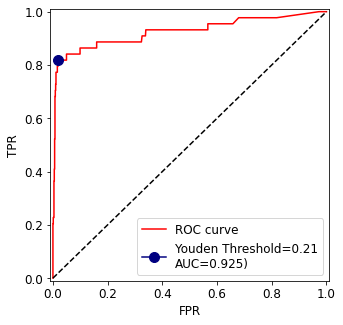

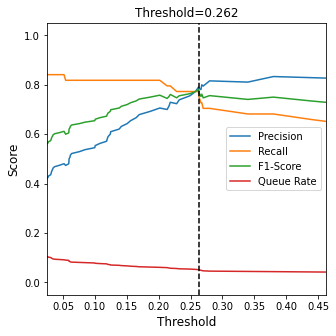

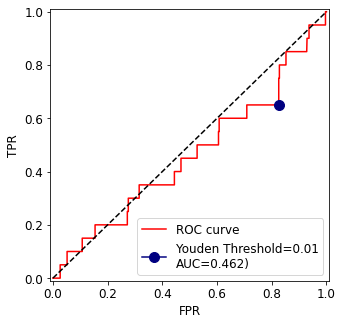

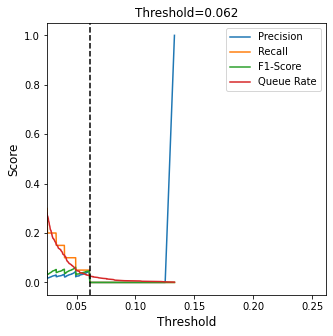

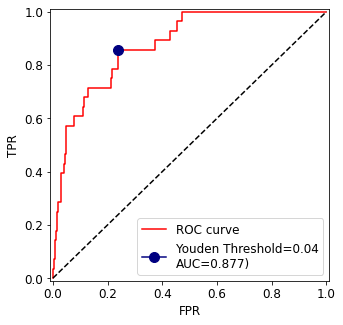

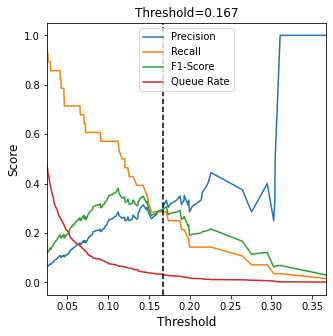

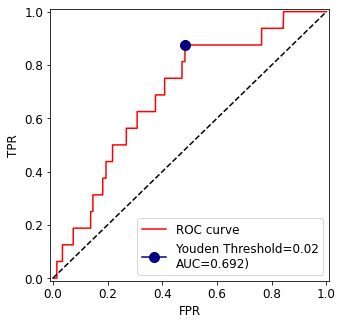

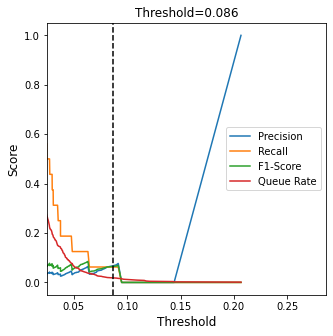

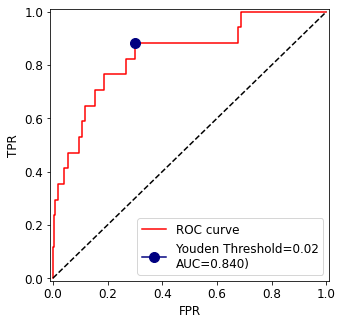

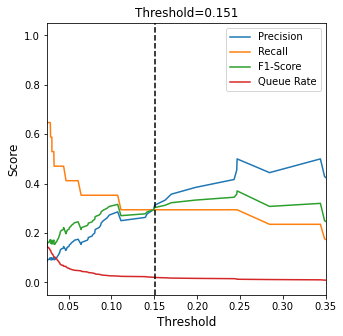

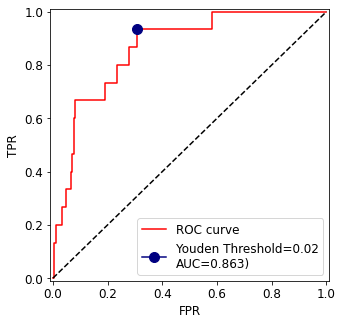

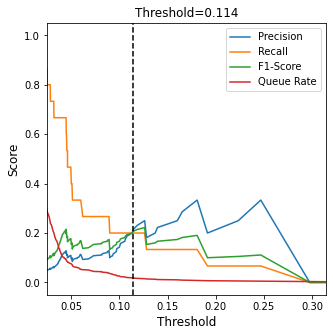

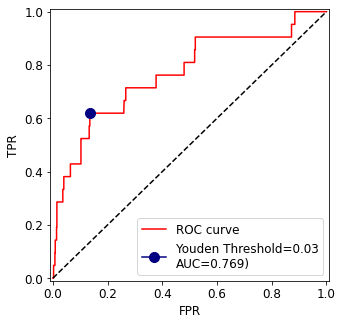

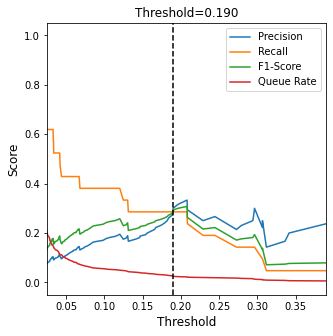

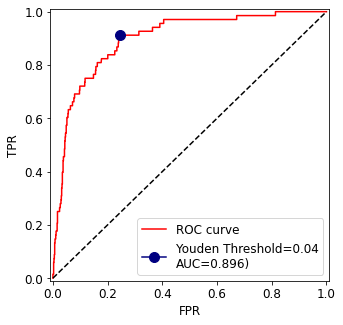

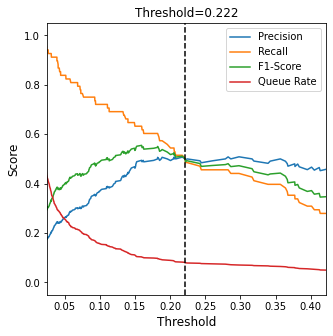

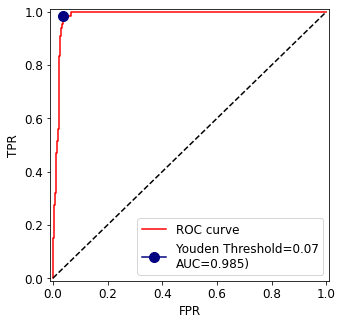

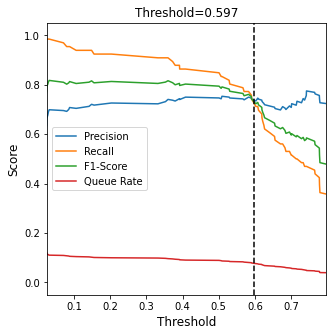

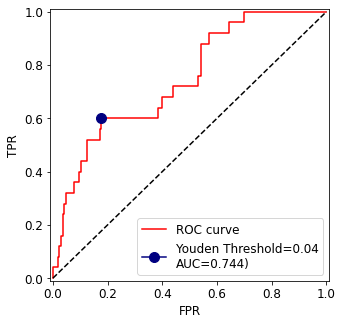

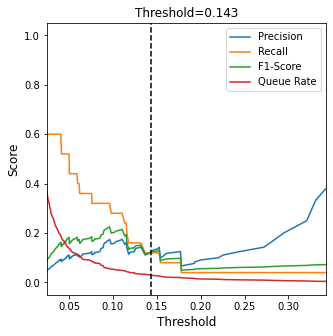

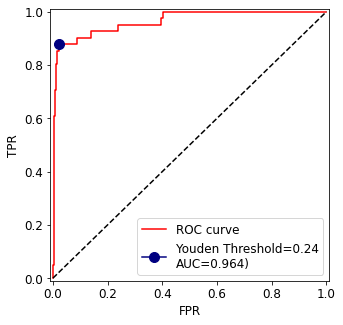

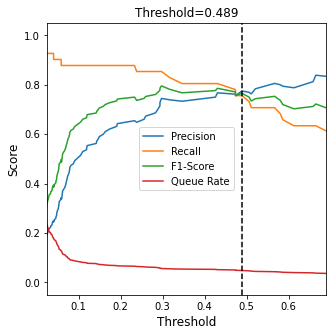

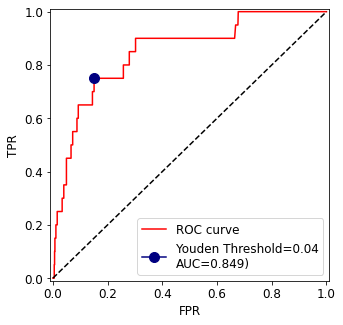

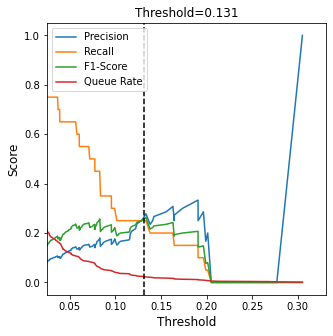

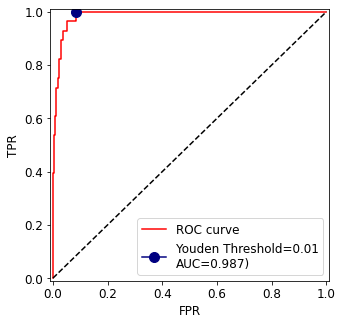

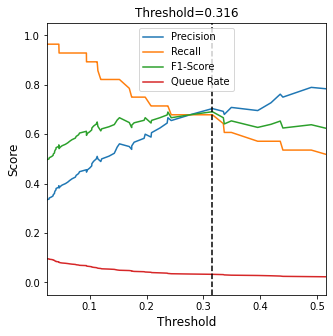

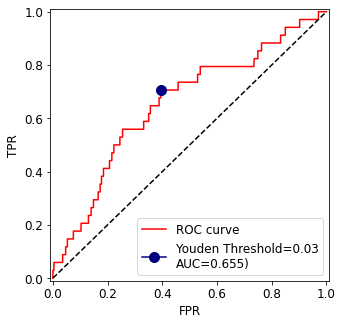

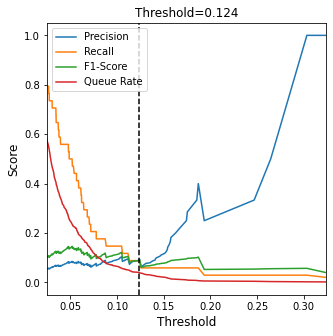

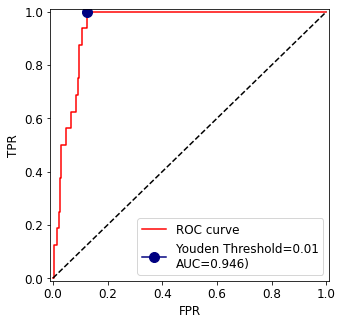

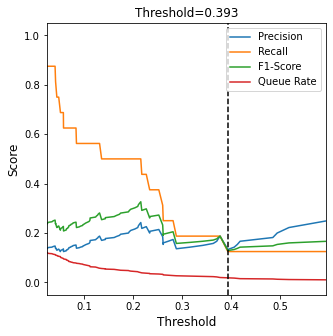

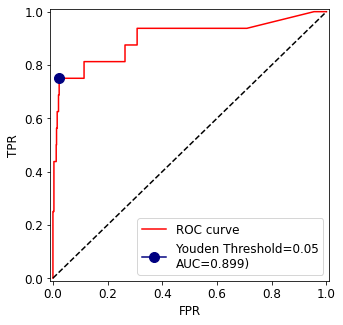

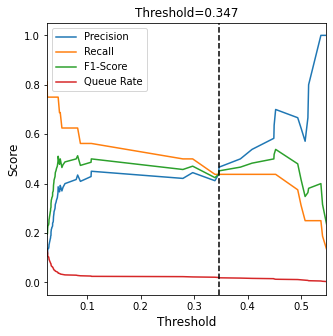

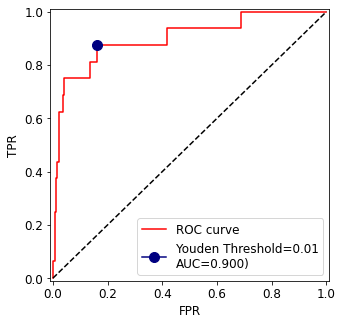

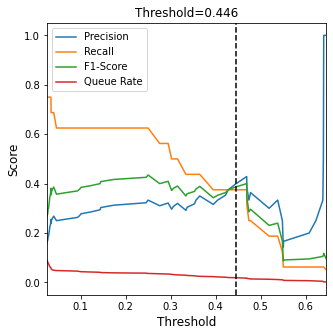

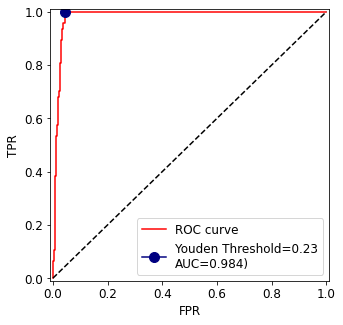

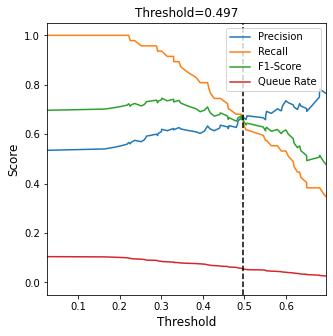

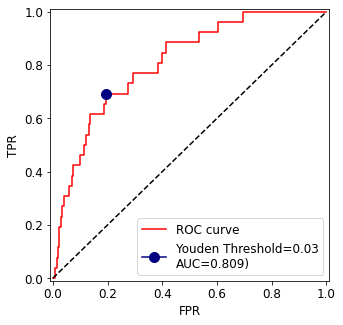

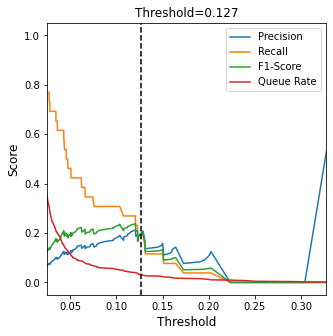

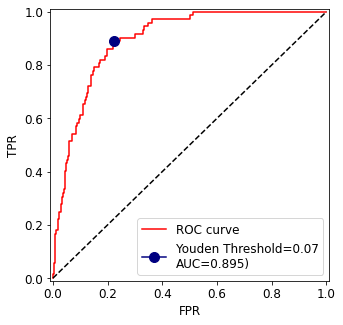

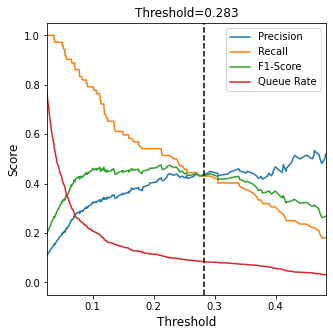

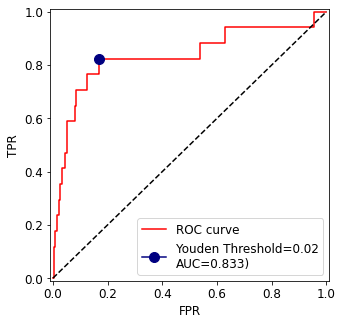

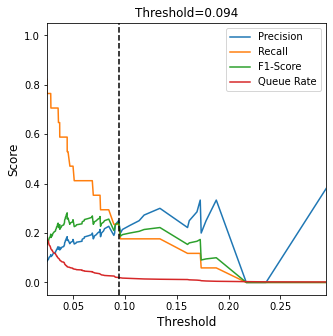

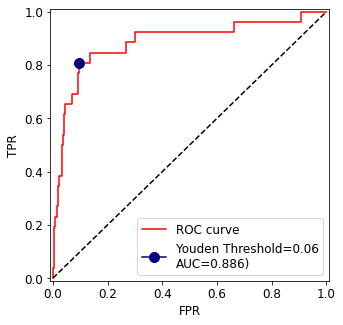

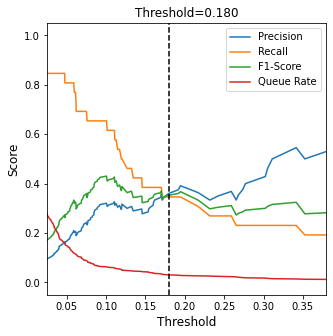

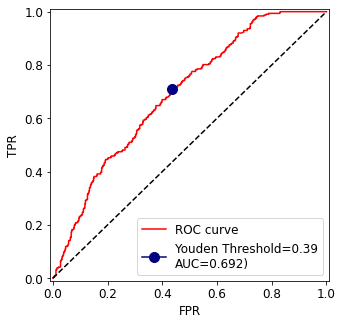

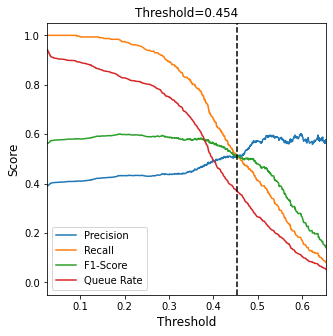

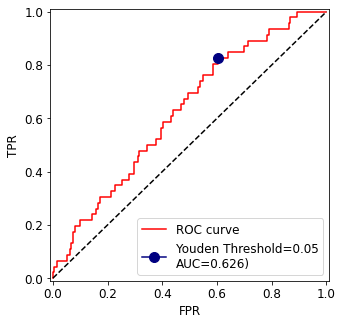

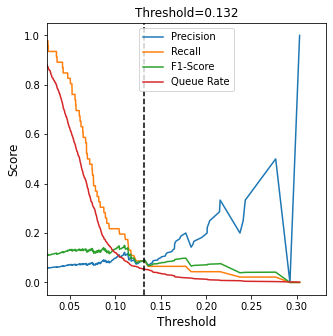

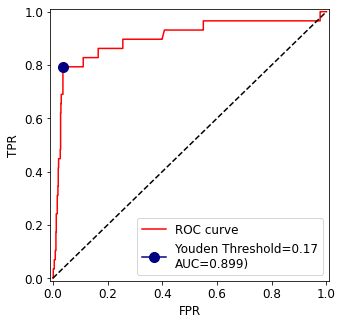

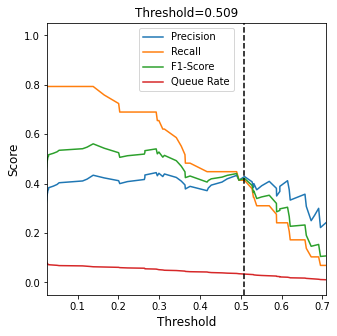

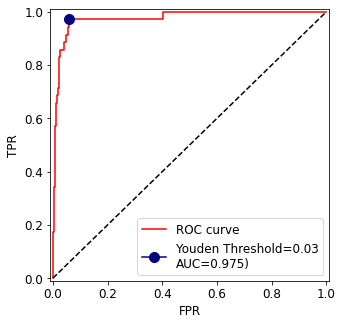

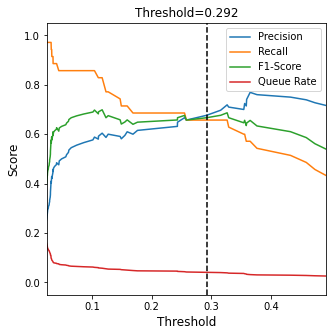

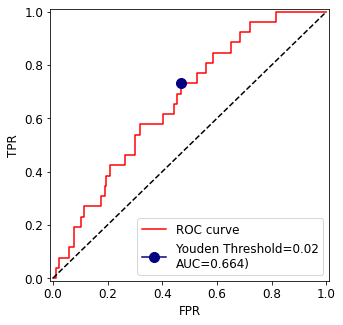

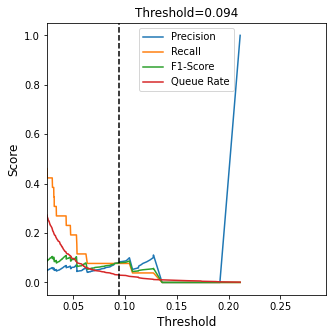

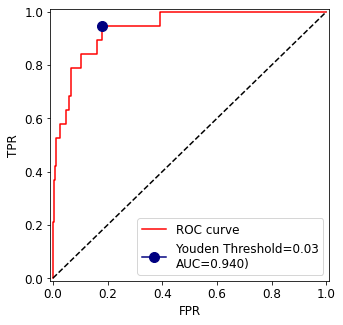

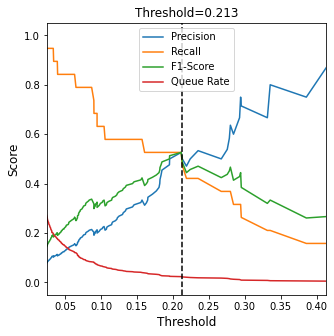

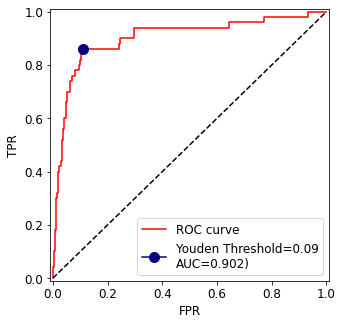

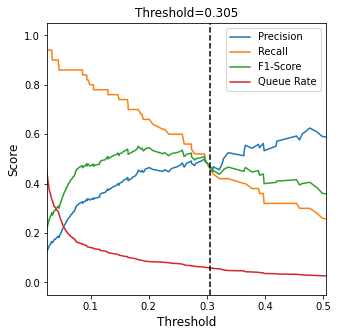

In [63]:
evaluate(X_train, X_test, y_train, y_test, tags)